# Convolutional Neural Networks with PyTorch CNN

Reference:

* `torch.nn` documentation http://pytorch.org/docs/master/nn.html
* Convolution animations. Make sure to understand these animations so you can visualize stride, padding, etc. https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* If you want to look at something more complicated, check out the ResNet implementation in torchvision: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [2]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

## Data Format

Dimension ordering is very important. For pytorch:

* 2D data like images should be `(samples, channels, height, width)` sometimes called "NCHW" or "channels first"
* 1D data like stock prices should be `(samples, channels, time)`
* 2D filters should be `(out_channels, in_channels, height, width)`
* 1D filters should be `(out_channels, in_channels, time)`

Different frameworks (e.g., TensorFlow) use different dimension orderings so be very careful, especially when implementing code or reading data targeted at a different framework.

Note most image data is RGB but some is BGR  or ARGB.

In [3]:
input_image = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(input_image.size())
input_signal = autograd.Variable(torch.randn(1,40,100)) # 40 dimensional signal for 100 timesteps
print(input_signal.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 40, 100])


## Convolutional Layers

The `torch.nn` module provides layers for CNNs. Use in the same way as other modules. Please refer to the documentation for details. Some of the most common layers you will use:

* `torch.nn.Conv2d`
* `torch.nn.ConvTranspose2d`
* `torch.nn.MaxPool2d`
* `torch.nn.AvgPool2d`


In [4]:
# Create layers
layer_c2d = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
layer_avg = torch.nn.AvgPool2d(kernel_size=32)

In [5]:
# Use layers directly
y = layer_c2d(input_image)
print(y.size())

torch.Size([1, 20, 32, 32])


In [6]:
# Add layers to model
model = torch.nn.Sequential(layer_avg, layer_c2d)
y = model(input_image)
print(y.size())

torch.Size([1, 20, 1, 1])


## Convolutional Functions

The `torch.nn.functional` module provides low-level functions. Depending on what kinds of models you are making, you may never have to use these functions, and use pre-made layers instead. When using the functional module, you need to instantiate parameters yourself.

http://pytorch.org/docs/0.1.12/nn.html#torch-nn-functional

Example low-level functions:

* `F.max_pool2d`
* `F.dropout2d`
* `F.conv2d`

In [7]:
filters = autograd.Variable(torch.randn(20,3,5,5)) # 5x5 filter from 3 dimensions to 20
y=F.conv2d(input_image, filters, padding=2)
print(y.size())

torch.Size([1, 20, 32, 32])


In [8]:
filters = autograd.Variable(torch.randn(256,40,5)) # 5 wide filter from 40 dimensions to 256
y=F.conv1d(input_signal, filters, padding=2)
print(y.size())

torch.Size([1, 256, 100])


For example, if you generate the kernel using a neural network, you will have to use the functional module instead of a standard convolutional layer.

## Padding

Simple 0-padding can be accomplished using the `padding` keyword argument of many functions. Normally, you will be using the same vertical and horizontal padding but you can also pass a tuple `(H,W)`. Padding is applied symmetrically.

In [9]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=0)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=1)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=2)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=3)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=(0,3))(inputs).size())

torch.Size([1, 20, 26, 26])
torch.Size([1, 20, 28, 28])
torch.Size([1, 20, 30, 30])
torch.Size([1, 20, 32, 32])
torch.Size([1, 20, 26, 32])


For more complicated padding, use a padding layer before your convolution.

* Single int: apply to all sides
* tuple (H,W): apply H to top and bottom, W to left and right
* tuple (left, right, top, bottom)

In [10]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
y = torch.nn.Conv2d(3, 20, 7)(torch.nn.ReplicationPad2d(3)(inputs))
print(y.size())

torch.Size([1, 20, 32, 32])


Common padding layers:

* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

## Normalization and Dropout

Don't forget BatchNorm2d and Dropout2d if you want to improve performance!

In [11]:
h = nn.Conv2d(3, 20, 5, padding=2)(input_image)
h = nn.BatchNorm2d(20)(h)
h = F.relu(h)
h = nn.Dropout2d(0.5)(h)
print(h.size())

torch.Size([1, 20, 32, 32])


## Downsampling

You can downsample using pooling operations or strided convolutions.

In [12]:
# Simple pooling operations
print(nn.MaxPool2d(2)(input_image).size())
print(nn.AvgPool2d(2)(input_image).size())

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [13]:
# Strided convolution
layer = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=2, padding=2)
print(layer(input_image).size())

torch.Size([1, 20, 16, 16])


## Reading Image Data

Reference:
http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**Warning** `skimage`, `Pillow` and `matplotlib` expect (H, W, channels). Make sure to transpose dimensions when going to and from pytorch.

(693, 1024, 3)


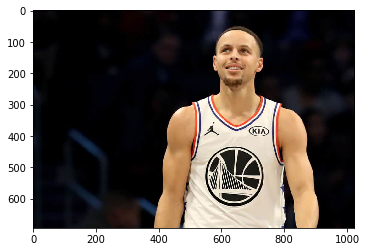

In [14]:
# Read an image using skimage
from skimage import io
image = io.imread('https://mk0slamonlinensgt39k.kinstacdn.com/wp-content/uploads/2019/02/GettyImages-1130407055.jpg') # Add the path to your image
print(image.shape)
# Display an image
plt.imshow(image)
plt.show()

## Basic Pytorch Model

In [15]:
class BasicCNNModule():
        def __init__(self, in_feature, num_class):

            self.conv1 = nn.Conv2d(in_feature, in_feature*2,
                        kernel_size=5, stride=1)
            self.conv2 = nn.Conv2d(in_feature*2, in_feature*2,
                        kernel_size=6, stride=2)

            self.act1 = nn.Tanh()
            self.act2 = nn.ReLU()
            self.linear = nn.Linear(in_feature*10, num_class)

            self.__layers = [self.conv1, self.act1,
                           self.conv2, self.act2,
                           self.linear]

        def forward(self, x):
            for layer in self.__layers:
                x = layer(x)

            return x
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return
        
print(BasicCNNModule(100, 10))

In [16]:
class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
            self.drop_out = nn.Dropout()
            self.fc1 = nn.Linear(7 * 7 * 64, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            out = self.drop_out(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return
        
print(BasicCNNModule(100, 10))

# Coding Task 1 (25 Points)

## Now write a piece of code to train the above designed CNN Model using MNIST images. You can modify the architecture of the network as well if you would like.


MNIST Images: http://yann.lecun.com/exdb/mnist/
A very useful blog for this lab would be https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/ to get the full model running.

*Part marks will be awarded for partially working code

#### Feel free to use any online resource to complete this task, just make sure your put the link to all the resources that you used to solve this part of the assignment.

In [17]:
from torchvision.datasets import MNIST

num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = MNIST('./data', train=True, transform=trans, download=True)
test_dataset = MNIST('./data', train=False, transform=trans)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

0.5%5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [18]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.1250, Accuracy: 95.00%
Epoch [1/5], Step [200/600], Loss: 0.1816, Accuracy: 96.00%
Epoch [1/5], Step [300/600], Loss: 0.1037, Accuracy: 96.00%
Epoch [1/5], Step [400/600], Loss: 0.1164, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.1105, Accuracy: 95.00%
Epoch [1/5], Step [600/600], Loss: 0.0973, Accuracy: 95.00%
Epoch [2/5], Step [100/600], Loss: 0.1760, Accuracy: 95.00%
Epoch [2/5], Step [200/600], Loss: 0.3880, Accuracy: 96.00%
Epoch [2/5], Step [300/600], Loss: 0.1507, Accuracy: 98.00%
Epoch [2/5], Step [400/600], Loss: 0.0711, Accuracy: 97.00%
Epoch [2/5], Step [500/600], Loss: 0.1137, Accuracy: 94.00%
Epoch [2/5], Step [600/600], Loss: 0.1104, Accuracy: 97.00%
Epoch [3/5], Step [100/600], Loss: 0.0849, Accuracy: 98.00%
Epoch [3/5], Step [200/600], Loss: 0.0653, Accuracy: 98.00%
Epoch [3/5], Step [300/600], Loss: 0.0446, Accuracy: 98.00%
Epoch [3/5], Step [400/600], Loss: 0.0226, Accuracy: 100.00%
Epoch [3/5], Step [500/600], Loss: 0.07

In [21]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 99.11 %


## Please see below the section on Pre-Trained Models and how they can be used as feature extractors. You should now use any pre-trained model such as the one shown below and extract features of an image of your choice and develop a simple  classifer using softmax, MLP or any other one you may want. Keep in mind the input image size before training your model.

Reference: 
https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469
https://medium.com/@tsakunelsonz/adding-custom-made-images-using-data-loaders-for-transfer-learning-in-five-steps-9d879bb5b80e  
https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469

In [22]:
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, datasets

In [23]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

In [24]:
train_data = datasets.ImageFolder("/Users/lirui/Desktop/data_586/data-586-lab-2-lirui315/data/train", transform=train_transform)
validation_data = datasets.ImageFolder("/Users/lirui/Desktop/data_586/data-586-lab-2-lirui315/data/validation", transform=train_transform)
test_data = datasets.ImageFolder("/Users/lirui/Desktop/data_586/data-586-lab-2-lirui315/data/test", transform=train_transform)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lirui/Desktop/data_586/data-586-lab-2-lirui315/data/train'

In [ ]:
trainLoader = DataLoader(train_data, batch_size=30, shuffle=True)
validLoader = DataLoader(validation_data, batch_size=30, shuffle=False)
testLoader = DataLoader(test_data, batch_size=30, shuffle=False)

## Pre-trained models

Training CNN models from scratch requires a lot of data. Hence we often use pre-trained models to alleviate this problem. For CNNs, pre-trained models are readily available for famos architectures such as VGG, ResNet and Inception Net.

When you set `pretrained=True`, torchvision automatically downloads the model for you, and initializes weights from there. If this does not work, run the following:
```
>> wget https://download.pytorch.org/models/vgg16-397923af.pth
>> mv vgg16-397923af.pth ~/.torch/models/vgg16-397923af.pth
```

Reference: https://pytorch.org/docs/stable/torchvision/models.html.

In [ ]:
#import models from torchvision
from torchvision import models
#build the pretrained model (vgg16 in this case)
model = models.vgg16(pretrained = True)

In [ ]:
#import OrderedDicted to corectly align the network layers
#import nn you use activation and dropout features
from collections import OrderedDict
from torch import nn
#create classifier
classifier=nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.337)),
                           ('fc2', nn.Linear(512, 102)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))
#replace the model's classifier with this new classifier 
#transfer learning connection applied here
model.classifier = classifier

In [ ]:
#import optimizer for 
from torch import optim
#define criteria and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.5)

In [ ]:
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(trainLoader.dataset)
    epoch_acc = current_correct.double() / len(trainLoader.dataset)
        
    return epoch_loss, epoch_acc

In [ ]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(validLoader.dataset)
    epoch_acc = valid_correct.double() / len(validLoader.dataset)
    
    return epoch_loss, epoch_acc

In [ ]:
cuda = torch.cuda.is_available()
cuda

In [ ]:
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
#train and validate
epochs = 10  
epoch = 0

    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainLoader, criteria, gpu=cuda)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validLoader, criteria, gpu=cuda)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

In [ ]:
# Testing the Modified Network

model.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, y_test in iter(testLoader):
    test, y_test = test.to('cpu'), y_test.to('cpu')
#Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

## We can build a VGG feature extractor. These are often useful in downstream tasks, for example learning deep visual semantic embeddings (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf). This allows us to use features trained on large datasets like ImageNet, and use on tasks which have lesser data.

## ``` vgg16.features ``` gives us convolutional features. Often, even taking all the layers until the last classification layer also suffices.


In [ ]:
vgg16_feature_extractor = vgg16.features
# print('VGG feature extractor', vgg16_feature_extractor)
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).size())
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).view(1, -1).size()) # flatten conv features

vgg16_4096 = models.vgg16(pretrained=True)
new_classifier = nn.Sequential(*list(vgg16_4096.classifier.children())[:-1]) # remove just the last layer
vgg16_4096.classifier = new_classifier
print(vgg16_4096(Variable(torch.rand(1, 3, 224, 224))).size())

In [ ]:
#import optimizer for 
from torch import optim
#define criteria and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_4096.parameters(), lr = 0.005, momentum = 0.5)

#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(trainLoader.dataset)
    epoch_acc = current_correct.double() / len(trainLoader.dataset)
        
    return epoch_loss, epoch_acc

#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(validLoader.dataset)
    epoch_acc = valid_correct.double() / len(validLoader.dataset)
    
    return epoch_loss, epoch_acc

In [ ]:
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in vgg16_4096.parameters():
    param.require_grad = False
#train and validate
epochs = 10  
epoch = 0

    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(vgg16_4096,trainLoader, criteria, gpu=cuda)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validLoader, criteria, gpu=cuda)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

In [ ]:
# Testing the Modified Network

model.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, y_test in iter(testLoader):
    test, y_test = test.to('cpu'), y_test.to('cpu')
#Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = vgg16_4096.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))